## Прогноз вероятности неврологических проявлений при болезни Вильсона-Коновалова. Линейная логистическая регрессия

* Импорт библиотек
* Чтение данных
* Группировка признаков
* Обработка пропусков в данных
* Отбор признаков
* Оптимизация параметров и оценка качества моделей
* Выводы

In [31]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 70)   # Настройка отображения данных в Jupyter notebook
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 3)

%pylab inline
# Visualization and Graphics
%matplotlib inline
import matplotlib.pyplot as plt

# !conda install seaborn 
import seaborn as sns
plt.rcParams['figure.figsize'] = (7,7)   # (8,6)

#!pip install ggplot
matplotlib.style.use('ggplot')       # Use ggplot style plots

Populating the interactive namespace from numpy and matplotlib


### Чтение данных

In [32]:
# Чтение данных из сохранённого файла
df_ext = pd.DataFrame()
df_ext = pd.read_csv('../Wilson_2/Wilson_ext.csv', sep=';', encoding='utf-8') 
print(df_ext.columns)

Index(['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'Sex M/F', 'BMI',
       'Height', 'Mass', 'BMI_scaled', 'Height_scaled', 'Mass_scaled', 'KKF',
       'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge',
       'DebutAge_scaled', 'DebutLiver', 'DebutNeuro', 'DebutKidney',
       'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez',
       'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB',
       'MTHFR_677', 'MTHFR_1298', 'F2__1', 'F5__1', 'F7__1', 'F13__1',
       'ITGA2__1', 'ITGB3__1', 'PAI_1__1', 'FGB__1', 'MTHFR_677__1',
       'MTHFR_1298__1', 'F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2',
       'ITGB3__2', 'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2',
       'F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 'F13_GG',
       'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 'ITGB3_TC',
       'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 'FGB_AA',
       'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_

### Пропуски в данных.
Заполним пропуски **средними значениями**. Это удобно для выбранного алгоритма.

In [33]:
for c in df_ext.columns:
    number_of_na = np.sum(df_ext[c].isna())            # Needs Pandas 22.0 or higher
    if number_of_na > 0:
        print(c, number_of_na, df_ext[c].mean())

df = df_ext.fillna(df_ext.mean())

print( df_ext[['TargetHeadRelativeMax', 'BMI']].fillna(df_ext.mean()).head(8) )

TargetHeadRelativeMax 71 0.5384615384615384
BMI 1 22.89808806306615
Height 3 1.7483950617283952
Mass 3 70.19135802469135
BMI_scaled 1 -0.025477984233461776
Height_scaled 3 -0.016049382716049512
Mass_scaled 3 0.012757201646090528
KKF 1 0.8072289156626506
   TargetHeadRelativeMax     BMI
0                  0.538  24.220
1                  0.538  19.493
2                  0.538  21.605
3                  0.000  18.145
4                  1.000  21.778
5                  0.538  21.295
6                  0.538  17.631
7                  0.538  22.898


### Группировка признаков

Группы выделены в соответствии со смыслом данных, форматом их представления, <br> планируемой логикой их обработки и использования.

- `target_features`, 
- `relatives_features`, 
- `sex_features`, `sex_features_cat`, 
- `bmi_features`, `bmi_features_scaled`,
- `symptom_features`, `cirrhosis_features`, 
- `debut_age_features`, `debut_age_features_scaled`,
- `debut_organ_features`,
- `genetic_features`, `genetic_features__1`, `genetic_features__2`, `genetic_features__dummy`, `genetic_risk_features`
- `exclude_features`

In [49]:
target_features        = ['TargetHead']                                                    # TargetHead = ifelse(Target == 3, 1, 0)
relatives_features     = ['TargetHeadRelativeMax']                                         # Наихудший диагноз у родсттвенников
sex_features           = ['Sex']                                                           # Пол
bmi_features           = ['BMI', 'Height', 'Mass']                                         # Идекс массы тела, Рост, Вес
symptom_features       = ['KKF']                                                           # Симптом: Кольца Кайзера — Флейшера
cirrhosis_features     = ['Cirrhosis', 'ChildPugh', 'Advanced', 'Activity']                # Цирроз: Стадия. Активность (динамика).
debut_age_features     = ['DebutAge']                                                      # Дебют заболвания: возраст
debut_organ_features   = ['DebutLiver', 'DebutNeuro', 'DebutKidney', 'DebutEndocr',        # Дебют заболвания: что выявили
                          'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther']
genetic_features       = ['F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3',                       # Генетические признаки 
                          'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298']
exclude_features       = ['Target', 'TargetRelativeMax']                                   # Исключить из данных
exclude_model_features = ['FamilyID', 'DebutNeuro'] + exclude_features                     # Исключить из модели

In [35]:
num_features_to_scale     = ['BMI','Height','Mass','DebutAge']                             # Числовые показатели
num_features_scaled       = ['BMI_scaled','Height_scaled','Mass_scaled','DebutAge_scaled']

# Группировка
bmi_features_scaled       = ['BMI_scaled','Height_scaled','Mass_scaled']
debut_age_features_scaled = ['DebutAge_scaled']

In [36]:
sex_features_cat = ['Sex M/F']

In [37]:
genetic_features__dummy = ['F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 
                           'F13_GG', 'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 
                           'ITGB3_TC', 'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 
                           'FGB_AA', 'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_677_CT', 'MTHFR_677_TT', 
                           'MTHFR_1298_AA', 'MTHFR_1298_AC', 'MTHFR_1298_CC']

genetic_features__1 = ['F2__1', 'F5__1', 'F7__1', 'F13__1', 'ITGA2__1', 'ITGB3__1', 
                       'PAI_1__1', 'FGB__1', 'MTHFR_677__1', 'MTHFR_1298__1']

genetic_features__2 = ['F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2', 'ITGB3__2', 
                       'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2']

genetic_risk_features = ['GenRisk__1', 'GenRisk__2', 'GenProtect__1', 'GenProtect__2']

In [50]:
def combine_features(all_feat_list, exclude_features):
    combined_list = list()
    for sublist in all_feat_list:
        for item in sublist:
            combined_list.append(item)
    combined_list = [x for x in combined_list if x not in exclude_features]
    return(combined_list)

In [51]:
data_features = combine_features([ target_features, relatives_features, sex_features, bmi_features, symptom_features, 
                                   cirrhosis_features, debut_age_features, debut_organ_features, genetic_features ],
                                 exclude_features)

print(data_features)

['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'BMI', 'Height', 'Mass', 'KKF', 'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge', 'DebutLiver', 'DebutNeuro', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298']


In [52]:
data_features_ext = combine_features(
                       [target_features, relatives_features, 
                        sex_features, sex_features_cat, 
                        bmi_features, bmi_features_scaled,
                        symptom_features, 
                        cirrhosis_features, 
                        debut_age_features, debut_age_features_scaled,
                        debut_organ_features,
                        genetic_features, genetic_features__1, genetic_features__2, genetic_features__dummy, 
                        genetic_risk_features ],
                       exclude_model_features)
print(model_columns)

['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'Sex M/F', 'BMI', 'Height', 'Mass', 'BMI_scaled', 'Height_scaled', 'Mass_scaled', 'KKF', 'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge', 'DebutAge_scaled', 'DebutLiver', 'DebutNeuro', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298', 'F2__1', 'F5__1', 'F7__1', 'F13__1', 'ITGA2__1', 'ITGB3__1', 'PAI_1__1', 'FGB__1', 'MTHFR_677__1', 'MTHFR_1298__1', 'F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2', 'ITGB3__2', 'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2', 'F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 'F13_GG', 'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 'ITGB3_TC', 'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 'FGB_AA', 'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_677_CT', 'MTHFR_677_TT', 'MTHFR_1298_AA', 'MTHFR_1298_AC', 'MTHFR_1298_CC', 'GenRisk__1', 'GenRis

### Отбор признаков

In [53]:
model_features = combine_features(
                       [
                        # target_features, 
                        relatives_features, 
                        sex_features, #sex_features_cat, 
                        # bmi_features, 
                        [bmi_features_scaled[0]],
                        symptom_features, 
                        [cirrhosis_features[0],cirrhosis_features[3]], 
                        # debut_age_features,
                        debut_age_features_scaled,
                        debut_organ_features,
                        # genetic_features, genetic_features__1, genetic_features__2, genetic_features__dummy, 
                        [genetic_risk_features[1],genetic_risk_features[3]]
                        ],
                       exclude_model_features)
print(model_features)

['TargetHeadRelativeMax', 'Sex', 'BMI_scaled', 'KKF', 'Cirrhosis', 'Activity', 'DebutAge_scaled', 'DebutLiver', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther', 'GenRisk__2', 'GenProtect__2']


In [57]:
# Без генетических факторов
model_0_features = combine_features(
                       [
                        # target_features, 
                        relatives_features, 
                        sex_features, #sex_features_cat, 
                        # bmi_features, 
                        [bmi_features_scaled[0]],
                        symptom_features, 
                        [cirrhosis_features[0],cirrhosis_features[3]], 
                        # debut_age_features,
                        debut_age_features_scaled,
                        debut_organ_features
                        # genetic_features, genetic_features__1, genetic_features__2, genetic_features__dummy, 
                        #[genetic_risk_features[1],genetic_risk_features[3]]
                        ],
                       exclude_model_features)
print(model_0_features)

['TargetHeadRelativeMax', 'Sex', 'BMI_scaled', 'KKF', 'Cirrhosis', 'Activity', 'DebutAge_scaled', 'DebutLiver', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther']


In [78]:
X, y = (df[model_features], np.array(df[target_features]).T[0])
X_0 = df[model_0_features]

In [79]:
y

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], dtype=int64)

### Оптимизация параметров и оценка качества моделей

In [59]:
from sklearn.linear_model    import LinearRegression, LogisticRegression, LassoCV, Lasso

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [70]:
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# param_grid = { 'C': np.logspace(-6, 2, 200) }
param_grid = { 'C': np.logspace(-6, 2, 17) }

grid_searcher = GridSearchCV( 
    estimator=LogisticRegression(random_state=42, penalty = 'l1'),
    param_grid= param_grid,
    scoring = 'roc_auc',
    cv=kfold, n_jobs=1)

In [80]:
%%time
grid_searcher.fit(X, y)
print('grid_searcher.fit(X, y) best score:', grid_searcher.best_score_, grid_searcher.best_params_)

grid_searcher.fit(X, y) best score: 0.797619047619 {'C': 0.31622776601683794}
Wall time: 1.3 s


In [82]:
%%time
grid_searcher.fit(X_0, y)
print('grid_searcher.fit(X_0, y) best score:', grid_searcher.best_score_, grid_searcher.best_params_)

grid_searcher.fit(X_0, y) best score: 0.780753968254 {'C': 1.0}
Wall time: 1.41 s


In [98]:
classifiers = { 'LogisticRegression C=0.78': LogisticRegression(random_state=42, penalty = 'l1', C=0.780753968254),
                'LogisticRegression C=1': LogisticRegression(random_state=42, penalty = 'l1', C=1) 
                }


In [84]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, KFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc

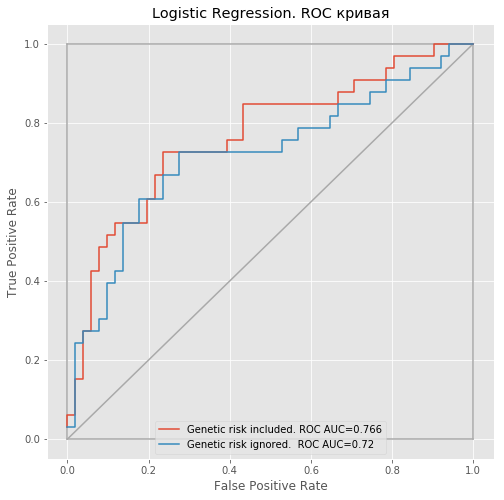

In [113]:
#figure(figsize=(6,6))
#plt.plot([0,1],[0,1],color='darkgray')

#for name, clf in classifiers.items():

name  = "Genetic risk included."
clf = LogisticRegression(random_state=42, penalty = 'l1', C=1) 
cv_predictions = cross_val_predict(clf, X, y,
                                       method='predict_proba',
                                       cv=LeaveOneOut() ) #  cv=10)


name_0  = "Genetic risk ignored."
clf_0 = LogisticRegression(random_state=42, penalty = 'l1', C=0.780753968254)
cv_predictions_0 = cross_val_predict(clf_0, X_0, y,
                                       method='predict_proba',
                                       cv=LeaveOneOut() ) #  cv=10)

fpr,   tpr,   thresh = roc_curve(y, cv_predictions[: ,1])
fpr_0, tpr_0, thresh = roc_curve(y, cv_predictions_0[: ,1])
    
figure(figsize=(8,8))
plt.plot([0,1],[0,1],color='darkgray')
plt.plot([0,0],[0,1],color='darkgray')
plt.plot([0,1],[0,0],color='darkgray')
plt.plot([0,1],[1,1],color='darkgray')
plt.plot([1,1],[0,1],color='darkgray')

plt.plot(fpr,   tpr,   label= name   #+ ' C=1     ' 
                              + ' ROC AUC=' + str( round(auc(fpr,   tpr  )*1000)/1000. ) )
plt.plot(fpr_0, tpr_0, label= name_0 #+ '  C=0.78 ' 
                              + '  ROC AUC=' + str( round(auc(fpr_0, tpr_0)*1000)/1000. ) )

xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('Logistic Regression. ROC кривая')
legend(loc='lower center');

plt.savefig('LogRegression.png', bbox_inches='tight')

### Выводы
* В данном рассчёте комбинированные генетические факторы (увеличения и снижения риска тромобза) способствовали улучшению качества предсказания по метрике ROC AUC: с 0.72 до 0.766. <br> Статистическая достоверность не оценивалась.